## Computation 8: Generalized linear models

We will explore examples of two types of generalized linear model: logistic regression, and Poisson regression.

## Part 1: Logistic regression 

In this problem, we will build a logistic regression model for predicting whether or not an individual will develop coronary heart disease. The dataset `heart_disease.csv` contains 15 features describing 3656 individuals, including sex, age, whether or not the individual is a smoker, as well as a variety of other health-related indicators. Once the data is downloaded from [this link](https://drive.google.com/drive/folders/1OkXMcFo0urN0kSQYH4d75I4V3pnSpV6H?usp=sharing), we can load it using the following.

In [1]:
import pandas as pd

dataset = pd.read_csv("heart_disease.csv")
# get rid of extra index column
dataset = dataset.drop("Unnamed: 0", axis=1)
print(dataset.shape)
dataset.head()

(3656, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Below we convert the data into numpy arrays.

In [2]:
import numpy as np

feature_cols = [c for c in dataset.columns if c != "TenYearCHD"]
X = dataset[feature_cols].to_numpy()
y = dataset["TenYearCHD"].to_numpy()
ones = np.ones((X.shape[0],1))
X = np.hstack([ones, X])

**Problem 1.** Split the dataset into a training and hold-out set, where the hold-out set contains 1000 individuals, and the rest are kept in the training set. Fit a logistic regression model for this data (e.g. using the `statsmodels` package), and compute the classification error on the training and hold-out sets, using the usual classifier derived from the fitted coefficients $\hat{\beta}$:

$$
C(x) = \begin{cases}1 &  p_{\hat{\beta}}(x) \geq 1/2\\ 0 & p_{\hat{\beta}}(x) < 1/2\end{cases}
$$

where $p_{\hat{\beta}}(x) = \frac{1}{1+\exp(-\hat{\beta}\cdot x)}$ is the estimated probability of developing heart disease.

In [3]:
#split data
ix_test = np.random.choice(X.shape[0], 1000, replace=False)
ix_train = [j for j in range(X.shape[0]) if j not in ix_test]

X_train, y_train = X[ix_train], y[ix_train]
X_test, y_test = X[ix_test], y[ix_test]

#fit logistic regression model
import statsmodels.api as sm 
model = sm.Logit(y_train, X_train).fit()

# compute predicted probabilties
p_hat_train = model.predict(X_train)
p_hat_test = model.predict(X_test)

# treshold the predicted probabilities 
y_hat_train = (p_hat_train >= 0.5).astype(int)
y_hat_test = (p_hat_test >= 0.5).astype(int)

# compute the errors
error_train = np.mean(y_hat_train != y_train)
error_test = np.mean(y_hat_test != y_test)

print(f"training error = {round(error_train,3)}, test error = {round(error_test,3)}")

Optimization terminated successfully.
         Current function value: 0.375931
         Iterations 7
training error = 0.145, test error = 0.147


**Problem 2.** Compute and plot an ROC curve using the hold-out set of data for the fitted logistic regression model, and compute the associated AUC. Then, suppose that we wanted to choose a threshold $t \in (0,1)$ such that the classifier 

$$
C_t(x) = \begin{cases}1 & p_{\hat{\beta}}(x) \geq t\\ 0 & p_{\hat{\beta}}(x) < t\end{cases}
$$

had a false positive rate of less than 20%. What value of $t$ should we choose? What would be the corresponding true positive rate at this threshold be?

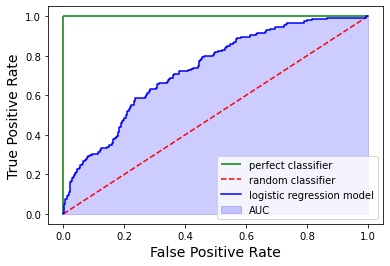

AUC:  0.7318857265665776
To get a false positive rate of less than 20%, we should choose a value larger than or equal to  0.21  for 𝑡. The corresponding true positive rate at this threshold would be  0.461038961038961 .


In [4]:
#ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

FPRs, TPRs, _ = roc_curve(y_test, p_hat_test)

plt.vlines(0,0,1, color='green', label="perfect classifier")
plt.hlines(1,0,1, color='green')
plt.plot([0,1], [0,1], color='red', linestyle='--', label="random classifier")
plt.plot(FPRs, TPRs, color="blue", label="logistic regression model")
plt.fill_between(FPRs, [0]*len(TPRs), TPRs, color="blue", alpha=0.2, label="AUC")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend()
plt.show()


#AUC
from sklearn.metrics import auc
AUC = auc(FPRs, TPRs)
print('AUC: ', AUC)


#find t
ix_pos = np.argwhere(y_test == 1)
ix_neg = np.argwhere(y_test == 0)

n_pos = np.sum(y_test==1)
n_neg = np.sum(y_test==0)

ts = np.linspace(0, 1, num = 101)
FPRs = []
for t in ts:
    y_hat_test = (p_hat_test >= t).astype(int)
    n_false_pos = np.sum(y_hat_test[ix_neg] == 1)
    FPR = n_false_pos/n_neg
    FPRs.append(FPR)
    
FPR_less_than_20 = [idx for idx, val in enumerate(FPRs) if val < 0.2]
t = min(ts[FPR_less_than_20])

y_hat_test = (p_hat_test >= t).astype(int)
n_true_pos = np.sum(y_hat_test[ix_pos] == 1)
TPR = n_true_pos/n_pos

print('To get a false positive rate of less than 20%, we should choose a value larger than or equal to ', t, ' for 𝑡.',
      'The corresponding true positive rate at this threshold would be ', TPR,'.')

**Problem 3.** (_Odds ratios_.) Once we've fitted a logistic regression model, an important thing we can estimate are _odds ratios_ derived from the model, which we explore in this problem. First, we can define the odds of an individual with attributes $X=x$ developing heart disease as:

$$
\rho = \frac{P(Y=1\mid X=x, \beta)}{1 - P(Y=1\mid X=x, \beta)} = e^{\beta\cdot x}
$$

Odds greater than 1 indicates that the individual is more likely than not to develop heart disease, whereas odds less than 1 indicate than an individual is less likely to develop heart disease than to. Then given two individuals with attributes $X=x$ and $X = x'$, the _odds ratio_ is a measure of how much higher the odds are for $x'$ than for $x$:

$$
\theta = \frac{P(Y=1\mid X=x', \beta)/(1 - P(Y=1\mid X=x', \beta))}{P(Y=1\mid X=x, \beta)/(1 - P(Y=1\mid X=x, \beta))} = \frac{e^{\beta\cdot x'}}{e^{\beta \cdot x}} = e^{\beta\cdot (x' - x)}.
$$

Now suppose that we change the $j$th feature $x_j$ by a single unit, i.e. $x_j' = x_j + 1$. Then we can estimate how much this increases the odds of developing heart disease by calculating the odds ratio for $x = (x_1,\dots, x_p)$ and $x' = (x_1,\dots,x_j', \dots, x_p)$.

$$
\theta = e^{\beta\cdot (x' - x)} = e^{\beta_j (x_j' - x_j)} = e^{\beta_j}.
$$

Therefore, the odds ratio when increase $x_j$ by one unit can be calculated _independent_ of the values of the other attributes. This allows us to estimate the marginal effect of a change in attribute $j$, by plugging in $\hat{\beta}_j$ to the above formula.

Use this approach to estimate:
1. The change in the odds of developing heart disease if an individual is a smoker.
2. The change in the odds of developing heart disease if an individual smokes 1 more cigarette per day.

In [6]:
from math import exp

#1
#x4 is currentSmoker
coef_x4 = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef'].values[4]
theta1 = exp(coef_x4)
print('The change in the odds of developing heart disease if an individual is a smoker:', theta1)


#2
#x5 is cigsPerDay
coef_x5 = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef'].values[5]
theta2 = exp(coef_x5)
print('The change in the odds of developing heart disease if an individual is a smoker:', theta2)

The change in the odds of developing heart disease if an individual is a smoker: 0.9757001140283413
The change in the odds of developing heart disease if an individual is a smoker: 1.022652763774634


## Part 2: Poisson regression

In this problem, we investigate a different type of GLM called Poisson regression. In this case, as the name of the model suggests, we assume that our response variable $Y$ conditioned on $X=x$ follows a Poisson distribution with rate parameter $\lambda = \lambda(x)$. Recall that the PMF of the Poisson distribution is

$$
p(Y=y \mid \lambda) = \frac{e^{-\lambda} \lambda^{y}}{y!} 
$$

for $y\in \{0,1,2,\dots\}$. Note that if $Y \mid X=x$ follows a Poisson distribution, then $\mathbb{E}[Y\mid X=x] = \lambda$.

This is a natural distribution to choose when our response is a count (such as number of calls, number of deaths, etc). In this case, we typically use the link function $g(z) = \log(z)$, and model 

$$
\lambda = \mathbb{E}[Y\mid X=x, \beta] = \exp(\beta \cdot x) \iff \log(\lambda) = \beta\cdot x
$$

i.e. we model the log-rate parameter of the Poisson distribution (conditional on $X=x$) as the linear model $\beta\cdot x$ (note that this ensures that $\lambda$ is always $\geq 0$).

To fit a Poisson regression model to observed data $(x_i, y_i)_{i=1}^n$ (where in this case the $y_i$'s are positive integers), we can minimize the negative log-likelihood, which is given by

$$
\ell(\beta) = \sum_{i=1}^n \left[\log(y_i!) + \exp(\beta\cdot x_i) - y_i\beta\cdot x_i \right].
$$

In python, we can use the `statsmodels` package to fit a Poisson regression model.

To try out Poisson regression, we will use the NYC East River Bicycle Counts dataset. Once downloaded, the dataset can be loaded with the following.

In [7]:
dataset = pd.read_csv("nyc-east-river-bicycle-counts.csv")
dataset.head()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0.00,1416.0,2617,3081.0,2357.0,9471
4,5,2016-04-06 00:00:00,2016-04-06 00:00:00,45.0,30.0,0.00,1885.0,3329,3856.0,2849.0,11919


For the sake of this problem, we will use a subset of the data, namely we will consider the features High Temp, Low Temp and Precipitation, and try to model the number of bikes on the Brooklyn bridge as a function of these features.

In [8]:
feature_cols = ["High Temp (°F)", "Low Temp (°F)", "Precipitation"]
X = dataset[feature_cols].to_numpy()
y = dataset["Brooklyn Bridge"].to_numpy()

ones = np.ones((X.shape[0],1))
X = np.hstack([ones, X])
X.shape, y.shape

((196, 4), (196,))

**Problem 1.** Use the `statsmodels` package to fit a Poisson regression model to this dataset (you can use the function `sm.GLM(y, X, family=sm.families.Poisson()).fit()` for this). Interpret what the coefficient for the feature "Precipitation" represents.

In [9]:
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(model.summary())

#-3.0416 represents a change in log(number of bikes on the Brooklyn bridge) for a unit increase in precipitation, which corresponds to a factor of e^(-3.0416) change in the original variable, the number of bikes on the Brooklyn bridge.


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  196
Model:                            GLM   Df Residuals:                      192
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15963.
Date:                Fri, 11 Nov 2022   Deviance:                       30072.
Time:                        21:35:22   Pearson chi2:                 2.82e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3521      0.010    647.785      0.0

**Problem 2.** Using the model fit in the previous problem, compute the expected increase in the number of bikes on the Brooklyn Bridge when "Precipitation decreases by 10%.

In [10]:
exp((-0.1) * (-3.0416))

#A (-0.1) unit increase in precipitation corresponds to a factor of exp((-0.1) * (-3.0416)) change in the original variable, the number of bikes on the Brooklyn bridge.


1.3554859164870152